<h1>SVHN Classification using CNNs</h1>

---



# Importing Keras Modules


In [2]:
#Importing important modules
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
#Installing Tensorboard for Colab
!pip install tensorboardcolab

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading the Dataset

<h3>Import train and test sets of  SVHN dataset</h3>

In [4]:
import h5py
import numpy as np

# Open the file as readonly
h5f = h5py.File('/content/drive/My Drive/DLCP/Project-1/Data/SVHN_single_grey1.h5', 'r')

# Load the training, test and validation set
x_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
x_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]


# Close this file
h5f.close()

x_test.shape

(18000, 32, 32)

<h4>Visualizing the dataset</h4>
(Visualize first 25 test images from the dataset using matplotlib) 

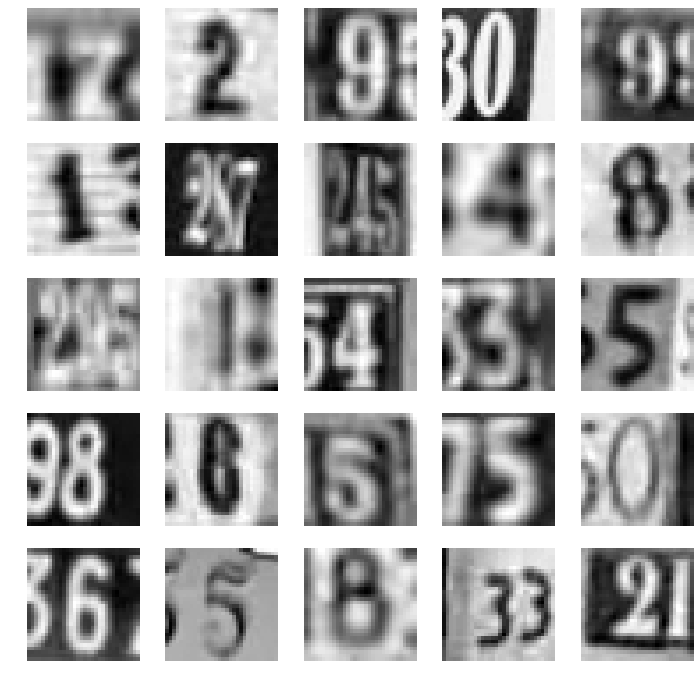

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
rows = 5
cols = 5
for i in range(1, rows*cols + 1):
  img = x_test[i]
  fig.add_subplot(rows, cols, i)
  plt.imshow( img, interpolation='nearest', cmap='gray')
  plt.axis('off')
plt.show()  

<h3>Reshape train and test sets into shapes compatible with keras models</h3>

<h4>Keras expects data to be in the format (N_E.N_H,N_W,N_C)  N_E = Number of Examples, N_H = height, N_W = Width, N_C = Number of Channels.</h4>


In [0]:
# input image dimensions
img_rows, img_cols = 32, 32

#Keras expects data to be in the format (N_E.N_H,N_W,N_C)
#N_E = Number of Examples, N_H = height, N_W = Width, N_C = Number of Channels.
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

<h3>Pre-processing the dataset</h3>
<h4>Normalizing the input</h4>

In [8]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#Normalizing the input
x_train /= 255.0
x_test /= 255.0
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


x_train shape: (42000, 32, 32, 1)
42000 train samples
18000 test samples


In [0]:
batch_size = 128
num_classes = 10
epochs = 12

<h4>Convert Labels from digits to one hot vectors</h4>  

In [10]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print("y_train",y_train.shape,"y_test",y_test.shape)
print(y_train[0])

y_train (42000, 10) y_test (18000, 10)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


# Building the CNN 

<h4>Define the layers of model</h4>  

In [0]:
model = Sequential()

#Add a Convolutional Layer with 32 filters of size 3X3 and activation function as 'ReLU' 
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
#Add a Convolutional Layer with 64 filters of size 3X3 and activation function as 'ReLU' 
model.add(Conv2D(64, (3, 3), activation='relu'))

#Add a MaxPooling Layer of size 2X2 
model.add(MaxPooling2D(pool_size=(2, 2)))

#Apply Dropout with 0.25 probability 
model.add(Dropout(0.25))

#Flatten the layer
model.add(Flatten())

#Add Fully Connected Layer with 128 units and activation function as 'ReLU'
model.add(Dense(128, activation='relu'))

#Apply Dropout with 0.5 probability 
model.add(Dropout(0.5))

#Add Fully Connected Layer with 10 units and activation function as 'softmax'
model.add(Dense(num_classes, activation='softmax'))

<h4>Set Adam Optimizer and Loss function for training</h4>  

In [0]:
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

#To use adam optimizer for learning weights with learning rate = 0.001
optimizer = Adam(lr=0.001)
#Set the loss function and optimizer for the model training
model.compile(loss=categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])

# Training the CNN 

<h4>Initializing the Tensorboard callback for visualization of training</h4>

In [0]:
#Import tensorboard callback which will passed in model.fit function.
from keras.callbacks import TensorBoard
from time import time


#Setting the directory to store the logs.
tensorboard = TensorBoard(log_dir="/content/drive/My Drive/logs/{}".format(time()))


<h4>Initializing Early stopping and Model chekpoint callbacks </h4>

In [0]:
#Adding Early stopping callback to the fit function is going to stop the training,
#if the val_loss is not going to change even '0.001' for more than 10 continous epochs

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training

model_checkpoint =  ModelCheckpoint('mnist_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)

<h4>Fit the model to the dataset</h4>

In [16]:
#Training on the dataset and adding the all the callbacks to the fit function.
#Once the training starts, results start appearing on Tensorboard after 1 epoch
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[tensorboard,early_stopping,model_checkpoint])

Instructions for updating:
Use tf.cast instead.
Train on 42000 samples, validate on 18000 samples
Epoch 1/12
42000/42000 [==============================] - 8s 181us/step - loss: 1.4355 - acc: 0.5262 - val_loss: 0.6924 - val_acc: 0.8099

Epoch 00001: val_loss improved from inf to 0.69241, saving model to mnist_cnn_checkpoint_01_loss0.6924.h5
Epoch 2/12
42000/42000 [==============================] - 4s 98us/step - loss: 0.7841 - acc: 0.7596 - val_loss: 0.5690 - val_acc: 0.8389

Epoch 00002: val_loss improved from 0.69241 to 0.56903, saving model to mnist_cnn_checkpoint_02_loss0.5690.h5
Epoch 3/12
42000/42000 [==============================] - 4s 97us/step - loss: 0.6714 - acc: 0.7934 - val_loss: 0.5074 - val_acc: 0.8476

Epoch 00003: val_loss improved from 0.56903 to 0.50739, saving model to mnist_cnn_checkpoint_03_loss0.5074.h5
Epoch 4/12
42000/42000 [==============================] - 4s 97us/step - loss: 0.6101 - acc: 0.8109 - val_loss: 0.4668 - val_acc: 0.8638

Epoch 00004: val_loss i

# Evaluating the CNN

<h4>Evaluate trained model on the test set</h4>  

In [17]:
#Testing the model on test set
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

18000/18000 [==============================] - 1s 64us/step
Test loss: 0.37537876578172047
Test accuracy: 0.8891666666666667


<h4>Visualize 5 test set image predictions</h4>  

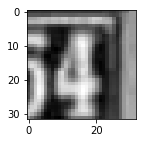

4


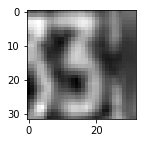

3


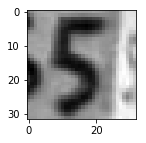

5


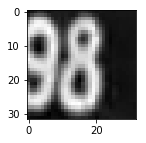

8


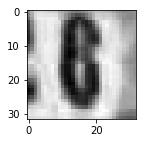

6


In [26]:
import numpy as np

for i in range(13,18):
  plt.figure(figsize=(2,2))
  plt.imshow(x_test[i].reshape(32,32),cmap="gray")
  plt.show()
  print(np.argmax(model.predict(x_test[i].reshape(1,32,32,1))))


# Saving the CNN

<h4>Save the trained weights and model in h5 files</h4>  

In [0]:
#Set the path where you want to store the model and weights. 
model.save('/content/drive/My Drive/DLCP/Project-1/model_svhn.h5')
model.save_weights('/content/drive/My Drive/DLCP/Project-1/cnn_svhn_weights.h5')